In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from collections import Counter
import string
import re
import seaborn as sns
from tqdm import tqdm
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.sequence import pad_sequences


In [2]:
is_cuda = torch.cuda.is_available()

# If we have a GPU available, we'll set our device to GPU. We'll use this device variable later in our code.
if is_cuda:
    device = torch.device("cuda")
    print("GPU is available")
else:
    device = torch.device("cpu")
    print("GPU not available, CPU used")

GPU is available


In [3]:
df = pd.read_csv("C:\Projects\I_am_learning\Dataset\IMDB_Dataset\IMDB_Dataset.csv")
df.head()

<>:1: SyntaxWarning: invalid escape sequence '\P'
<>:1: SyntaxWarning: invalid escape sequence '\P'
C:\Users\shail\AppData\Local\Temp\ipykernel_17052\1726255006.py:1: SyntaxWarning: invalid escape sequence '\P'
  df = pd.read_csv("C:\Projects\I_am_learning\Dataset\IMDB_Dataset\IMDB_Dataset.csv")


,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [4]:
# Divide the data to training and testing data
X,y = df['review'].values, df['sentiment'].values
X_train,X_test,y_train,y_test = train_test_split(X,y,stratify=y)
print(f'shape of train data is {X_train.shape}')
print(f'shape of test data is {X_test.shape}')

shape of train data is (37500,)
shape of test data is (12500,)


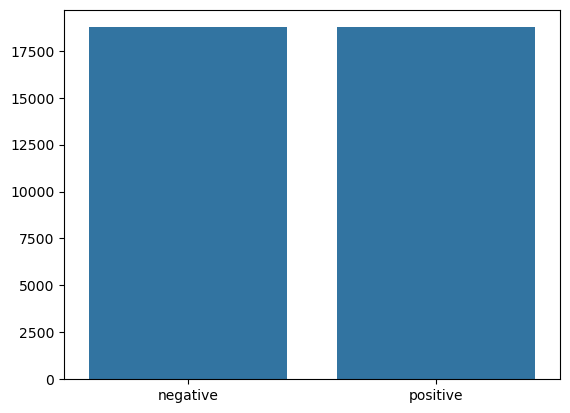

In [5]:
dd = pd.Series(y_train).value_counts()
sns.barplot(x=np.array(['negative','positive']),y=dd.values)
plt.show()

In [6]:
# Tokenize and Find Maximum Sentence Length
max_token_length = max(len(word_tokenize(sentence)) for sentence in X_test)

print("Maximum Sentence Length (after tokenization):", max_token_length)

Maximum Sentence Length (after tokenization): 2911


In [7]:
import gensim.downloader as api
from torch.utils.data import Dataset, DataLoader
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder
word2vec_model = api.load("glove-wiki-gigaword-50")  # 50-Dimensional GloVe Vectors
def text_to_embeddings(texts, max_length=500):
    tokenizer = Tokenizer(num_words=5000, oov_token="<OOV>")  # Tokenizer for vocab
    tokenizer.fit_on_texts(texts)
    
    # Convert text to sequences
    sequences = tokenizer.texts_to_sequences(texts)
    padded_sequences = pad_sequences(sequences, maxlen=max_length, padding="post")

    # Convert to Word Embeddings
    embeddings = np.zeros((len(texts), max_length, 50))  # Shape: (samples, max_len, embedding_dim)
    for i, seq in enumerate(padded_sequences):
        for j, word_index in enumerate(seq):
            word = tokenizer.index_word.get(word_index, "<OOV>")
            if word in word2vec_model:
                embeddings[i, j] = word2vec_model[word]  # Convert word to vector

    return embeddings, tokenizer

def encode_labels(labels):
    label_encoder = LabelEncoder()
    return label_encoder.fit_transform(labels)

class SentimentDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

def create_dataloader(X, y, batch_size=32):
    dataset = SentimentDataset(X, y)
    return DataLoader(dataset, batch_size=batch_size, shuffle=True)

def preprocess_nlp_data(texts, labels, max_length=500, batch_size=32):
    X_embeddings, tokenizer = text_to_embeddings(texts, max_length)
    y_encoded = encode_labels(labels)
    dataloader = create_dataloader(X_embeddings, y_encoded, batch_size)
    return dataloader, tokenizer

dataloader_train, tokenizer = preprocess_nlp_data(X_train, y_train, max_length=500, batch_size=32)
dataloader_test, tokenizer_test= preprocess_nlp_data(X_test, y_test, max_length=500, batch_size=32)

In [8]:
from models import LSTMModel
model = LSTMModel()
model.to(device)

LSTMModel(
  (lstm): LSTM(50, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

In [10]:
import torch.optim as optim
def acc(pred, label):
    pred = torch.round(pred.squeeze().detach())  # Detach from computation graph
    return torch.sum(pred == label.squeeze()).item()

lr = 0.001
epochs = 20
optimizer = optim.Adam(model.parameters(), lr=lr)
loss_fn = nn.BCELoss()
epoch_tr_loss,epoch_vl_loss = [],[]
epoch_tr_acc,epoch_vl_acc = [],[]
for epoch in range(epochs):
    model.train()
    total_loss = 0
    train_acc = 0.0
    vl_loss = 0
    vl_acc = 0.0
    for batchx,batchy in dataloader_train:
        batchx,batchy = batchx.to(device),batchy.to(device)
        optimizer.zero_grad()
        output = model(batchx).squeeze()
        loss = loss_fn(output,batchy.float())
        accuracy = acc(output,batchy)
        loss.backward()
        optimizer.step()
        total_loss +=loss.item()
        train_acc += accuracy
        
    model.eval()
    with torch.no_grad():
        for batchx,batchy in dataloader_test:
            batchx,batchy = batchx.to(device),batchy.to(device)
            output = model(batchx).squeeze()
            loss = loss_fn(output,batchy.float())
            accuracy = acc(output,batchy)
            vl_loss +=loss.item()
            vl_acc+= accuracy
    epoch_tr_loss.append(total_loss/len(dataloader_train))
    epoch_vl_loss.append(vl_loss/len(dataloader_test))
    epoch_tr_acc.append(train_acc/len(dataloader_train.dataset))
    epoch_vl_acc.append(vl_acc/len(dataloader_test.dataset))


    print(f"Epoch {epoch+1}/{epochs}, Train Loss: {total_loss/len(dataloader_train)}, validation Loss: {vl_loss/len(dataloader_test)}, Train accuracy: {train_acc/len(dataloader_train.dataset)}, validation accuracy: {vl_acc/len(dataloader_test.dataset)}")

Epoch 1/20, Train Loss: 0.6913880203364245, validation Loss: 0.6889240285929512, Train accuracy: 0.50952, validation accuracy: 0.51416
Epoch 2/20, Train Loss: 0.6873170880937739, validation Loss: 0.6855302748777677, Train accuracy: 0.51296, validation accuracy: 0.51856
Epoch 3/20, Train Loss: 0.6805929746542367, validation Loss: 0.6795495048813198, Train accuracy: 0.5409866666666666, validation accuracy: 0.52616
Epoch 4/20, Train Loss: 0.5196516007922412, validation Loss: 0.38372946623950965, Train accuracy: 0.70376, validation accuracy: 0.83272
Epoch 5/20, Train Loss: 0.36615091641735503, validation Loss: 0.36990839662149433, Train accuracy: 0.8372, validation accuracy: 0.83544
Epoch 6/20, Train Loss: 0.3397518152072263, validation Loss: 0.34152351601806746, Train accuracy: 0.8510933333333334, validation accuracy: 0.85536
Epoch 7/20, Train Loss: 0.31291250279967897, validation Loss: 0.31789483882658315, Train accuracy: 0.86464, validation accuracy: 0.86288
Epoch 8/20, Train Loss: 0.28

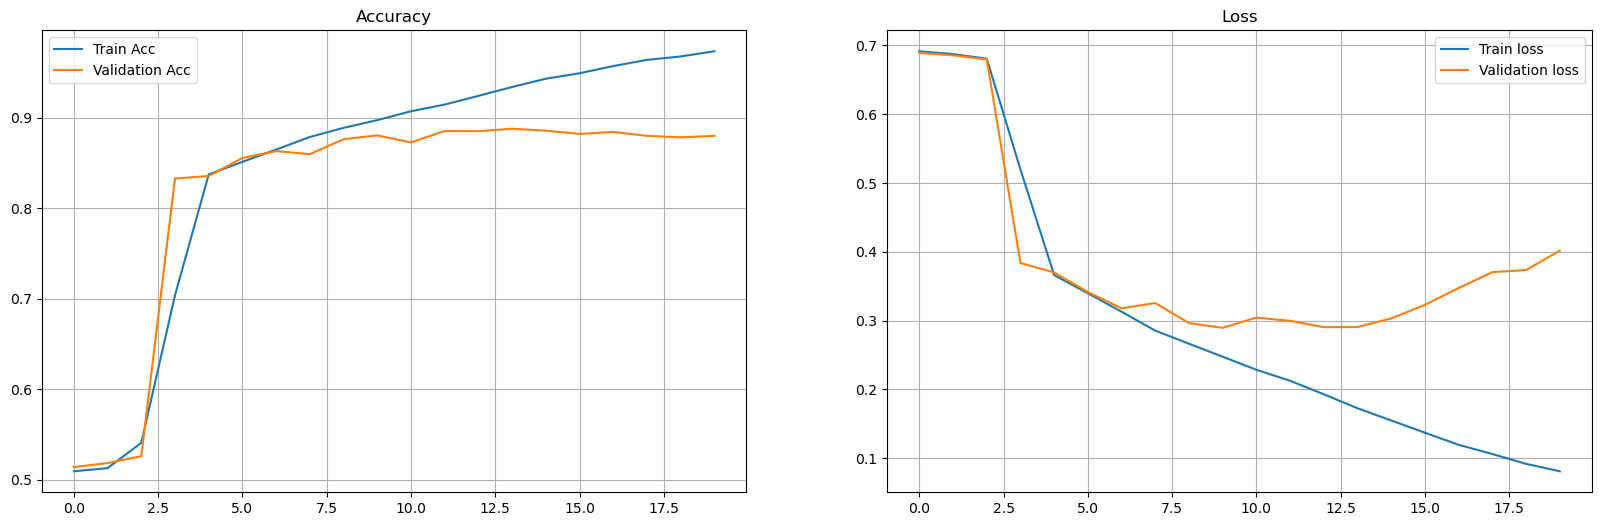

In [11]:
fig = plt.figure(figsize = (20, 6))
plt.subplot(1, 2, 1)
plt.plot(epoch_tr_acc, label='Train Acc')
plt.plot(epoch_vl_acc, label='Validation Acc')
plt.title("Accuracy")
plt.legend()
plt.grid()
    
plt.subplot(1, 2, 2)
plt.plot(epoch_tr_loss, label='Train loss')
plt.plot(epoch_vl_loss, label='Validation loss')
plt.title("Loss")
plt.legend()
plt.grid()

plt.show()